## Soft Actor-Critic: SAC in Cartpole

In [1]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  def __init__(self):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
  
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
    
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    done = terminated or truncated
    self.step_n += 1
    if self.step_n >= 200:
      done = True
    return state, reward, done, info 
  
env = MyWrapper()
env.reset()

array([-2.2192948e-02, -2.5615927e-02, -2.4060983e-02,  8.4321298e-05],
      dtype=float32)

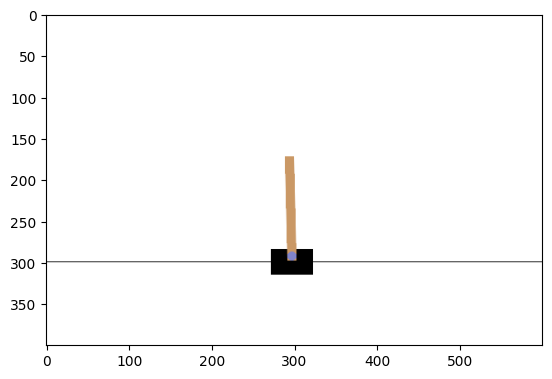

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline

# 打印游戏
def show():
  plt.imshow(env.render())
  plt.show()
  
show()

In [3]:
import torch

# 定义模型
model_action = torch.nn.Sequential(
	torch.nn.Linear(4, 128),
	torch.nn.ReLU(),
  torch.nn.Linear(128, 2),
  torch.nn.Softmax(dim=1),
)

model_action(torch.randn(2, 4))

tensor([[0.7698, 0.2302],
        [0.3734, 0.6266]], grad_fn=<SoftmaxBackward0>)

In [4]:
model_value1 = torch.nn.Sequential(
	torch.nn.Linear(4, 128),
	torch.nn.ReLU(),
	torch.nn.Linear(128, 2),
)
model_value2 = torch.nn.Sequential(
	torch.nn.Linear(4, 128),
	torch.nn.ReLU(),
	torch.nn.Linear(128, 2),
)

model_value_next1 = torch.nn.Sequential(
	torch.nn.Linear(4, 128),
	torch.nn.ReLU(),
	torch.nn.Linear(128, 2),
)
model_value_next2 = torch.nn.Sequential(
	torch.nn.Linear(4, 128),
	torch.nn.ReLU(),
	torch.nn.Linear(128, 2),
)

model_value_next1.load_state_dict(model_value1.state_dict())
model_value_next2.load_state_dict(model_value2.state_dict())

model_value1(torch.randn(2, 4))

tensor([[-0.0387,  0.2992],
        [ 0.0560,  0.1456]], grad_fn=<AddmmBackward0>)

In [5]:
import random

# 得到一个动作
def get_action(state):
  # 走神经网络，得到一个动作
  state = torch.FloatTensor(state).reshape(1, 4)
  prob = model_action(state)
  
  # 根据概率选择一个动作
  action = random.choices(range(2), weights=prob[0].tolist(), k=1)[0]
  
  return action

get_action([1, 2, 3, 4])

1

In [6]:
# 样本池
datas = []

#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
	old_count = len(datas)

	# 玩到新增N条数据为止
	while len(datas) - old_count < 200:
    # 初始化游戏
		state = env.reset()
  
		# 玩到结束
		over = False
		while not over:
			action = get_action(state)
			
			next_state, reward, over, _ = env.step(action)
			
			datas.append((state, action, reward, next_state, over))
			
			state = next_state
		
	update_count = len(datas) - old_count
	drop_count = max(len(datas) - 10000, 0)

	# 数据上限,超出时从最古老的开始删除
	while len(datas) > 10000:
		datas.pop(0)
    
	return update_count, drop_count

update_data(), len(datas)

((207, 0), 207)

In [7]:
# 获取一批数据样本
def get_sample():
  # 从样本池中采样
  samples = random.sample(datas, 64)
  
  # [b, 3]
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 4)
  # [b, 1]
  action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1)
  # [b, 1]
  reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
  # [b, 3]
  next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 4)
  # [b, 1]
  over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)
  
  return state, action, reward, next_state, over

state, action, reward, next_state, over = get_sample()

state[:5], action[:5], reward[:5], next_state[:5], over[:5]

C:\Users\fanyu\AppData\Local\Temp\ipykernel_26300\956863396.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 4)


(tensor([[-0.0062, -0.0275, -0.0221,  0.0290],
         [-0.0211, -0.0257, -0.0033, -0.0111],
         [ 0.0366, -0.0482, -0.0304, -0.0240],
         [ 0.0047,  0.4220, -0.0057, -0.6338],
         [-0.1229, -0.5584,  0.1408,  0.9289]]),
 tensor([[1],
         [0],
         [0],
         [1],
         [1]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]]),
 tensor([[-0.0068,  0.1680, -0.0215, -0.2706],
         [-0.0216, -0.2207, -0.0035,  0.2805],
         [ 0.0356, -0.2428, -0.0309,  0.2589],
         [ 0.0131,  0.6172, -0.0184, -0.9283],
         [-0.1341, -0.3655,  0.1593,  0.6835]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0]]))

In [8]:
from IPython import display

def test(play):
  #初始化游戏
  state = env.reset()
  
  #记录反馈值的和,这个值越大越好
  reward_sum = 0
  
  #玩到游戏结束为止
  over = False
  while not over:
    #根据当前状态得到一个动作
    action = get_action(state)
    
    #执行动作,得到反馈
    state, reward, over, _ = env.step(action)
    reward_sum += reward
    
    # 打印动画
    if play and random.random() < 0.2: # 跳帧
      display.clear_output(wait=True)
      show()
      
  return reward_sum

test(play=False)

11.0

In [9]:
def soft_update(model, model_next):
  for param, param_next in zip(model.parameters(), model_next.parameters()):
    # 小比例更新
    value = param_next.data * 0.995 + param.data * 0.005
    param_next.data.copy_(value)
    
soft_update(torch.nn.Linear(4, 64), torch.nn.Linear(4, 64))

In [10]:
import math

# 可学习参数
alpha = torch.tensor(math.log(0.01))
alpha.requires_grad = True

alpha

tensor(-4.6052, requires_grad=True)

In [11]:
def get_target(reward, next_state, over):
  # 首先使用model_action计算动作和动作的熵
  # [b, 4] -> [b, 2]
  prob = model_action(next_state)
  
  # 计算动作熵
  # [b, 2]
  entropy = prob * torch.log(prob + 1e-8)
  
  # 所有动作熵求和
  # [b, 2] -> [b, 1]
  entropy = -entropy.sum(dim=1, keepdim=True)
  
  # 评估next_state价值
  # [b, 4] -> [b, 2]
  target1 = model_value_next1(next_state)
  target2 = model_value_next2(next_state)
  
  # 取价值小的，出于稳定性
  # [b, 1]
  target = torch.min(target1, target2)
  
  # 求target期望
  # [b, 2] * [b, 2] -> [b, 2]
  target = (prob * target)
  # [b, 2] -> [b, 1]
  target = target.sum(dim=1, keepdim=True)
  
  # 还原alpha
  # target 加上动作熵，alpha作为权重系数
  # [b, 1] + [b, 1] -> [b, 1]
  target += alpha.exp() * entropy
  
  # [b, 2] 
  target *= 0.99
  target *= (1 - over)
  target += reward
  
  return target

get_target(reward, next_state, over).shape

torch.Size([64, 1])

In [12]:
def get_loss_action(state):
	# 计算动作的概率
	# [b, 4] -> [b, 2]
	prob = model_action(state)

	# 计算动作熵
	# [b, 2]
	entropy = prob * (prob + 1e-8).log()

	# 所有动作熵求和
	# [b, 2] -> [b, 1]
	entropy = -entropy.sum(dim=1, keepdim=True)

	
	# 使用两个value网络评估action的价值
	#[b, 4] -> [b, 2]
	value1 = model_value1(state)
	value2 = model_value2(state)

	# 取价值小的,出于稳定性考虑
	# [b, 1]
	value = torch.min(value1, value2)

	# 动作概率对价值加权
	# [b, 2] * [b, 2] -> [b, 2]
	value *= prob
	
	# 所有动作价值求和
	# [b, 2] -> [b, 1]
	value = value.sum(dim=1, keepdim=True)

	# 这里的操作是在target上加上了动作的熵,这个值越大越好
  # [b, 1] + [b, 1] -> [b, 1]
	loss_action = value + alpha.exp() * entropy
  
	# 因为是计算loss,所以对这个值符号取反
	return -loss_action.mean(), entropy

get_loss_action(state)

(tensor(-0.0236, grad_fn=<NegBackward0>),
 tensor([[0.6926],
         [0.6926],
         [0.6931],
         [0.6926],
         [0.6882],
         [0.6914],
         [0.6920],
         [0.6873],
         [0.6924],
         [0.6751],
         [0.6888],
         [0.6926],
         [0.6828],
         [0.6866],
         [0.6916],
         [0.6908],
         [0.6907],
         [0.6920],
         [0.6921],
         [0.6930],
         [0.6920],
         [0.6872],
         [0.6920],
         [0.6931],
         [0.6889],
         [0.6909],
         [0.6929],
         [0.6868],
         [0.6923],
         [0.6928],
         [0.6929],
         [0.6922],
         [0.6905],
         [0.6900],
         [0.6915],
         [0.6923],
         [0.6929],
         [0.6867],
         [0.6927],
         [0.6931],
         [0.6927],
         [0.6926],
         [0.6904],
         [0.6928],
         [0.6916],
         [0.6930],
         [0.6931],
         [0.6931],
         [0.6925],
         [0.6895],
        

In [13]:
def train():
  optimizer_action = torch.optim.Adam(model_action.parameters(), lr=1e-3)
  optimizer_value1 = torch.optim.Adam(model_value1.parameters(), lr=1e-2)
  optimizer_value2 = torch.optim.Adam(model_value2.parameters(), lr=1e-2)
  
  # alpha 也要更新
  optimizer_alpha = torch.optim.Adam([alpha], lr=1e-2)
  
  loss_fn = torch.nn.MSELoss()
  
  # 玩N局游戏，每句游戏训练一次
  for epoch in range(200):
    # 更新N条数据
    update_data()
    
    # 每次更新过后，学习N次
    for i in range(200):
      # 采样一批数据
      state, action, reward, next_state, over = get_sample()
      
      # 计算value和target, target已经考虑了动作和熵
      # [b, 1]
      target = get_target(reward, next_state, over)
      target = target.detach()
      
      # 计算两个value
      value1 = model_value1(state).gather(dim=1, index=action)
      value2 = model_value2(state).gather(dim=1, index=action)
      
      # 计算两个loss,两个value的目标都是要贴近target
      loss_value1 = loss_fn(value1, target)
      loss_value2 = loss_fn(value2, target)
      
      # 更新参数
      optimizer_value1.zero_grad()
      loss_value1.backward()
      optimizer_value1.step()
      
      optimizer_value2.zero_grad()
      loss_value2.backward()
      optimizer_value2.step()
      
      # 使用model_value计算model_action的loss, 更新参数
      loss_action, entropy = get_loss_action(state)
      optimizer_action.zero_grad()
      loss_action.backward()
      optimizer_action.step()
      
      # 熵乘以alpha就是alpha的loss
      # [b, 1] -> [1]
      loss_alpha = (entropy + 1).detach() * alpha.exp()
      loss_alpha = loss_alpha.mean()
      
      # 更新alpha值
      optimizer_alpha.zero_grad()
      loss_alpha.backward()
      optimizer_alpha.step()
      
      # 小比例更新
      soft_update(model_value1, model_value_next1)
      soft_update(model_value2, model_value_next2)
      
    if epoch % 20 == 0:
      test_result = sum([test(play=False) for _ in range(10)]) / 10
      print(epoch, len(datas), alpha.exp().item(), test_result)
      
train()

0 419 0.0026569173205643892 9.4
20 6474 2.5949440896511078e-05 190.9
40 10000 3.007133273058571e-06 173.2
60 10000 4.0758104091764835e-07 200.0
80 10000 5.843238781721993e-08 185.4
100 10000 7.99303556675568e-09 151.3
120 10000 1.2513480251996612e-09 200.0
140 10000 3.3242150698775674e-10 191.3
160 10000 1.4988726926290497e-10 200.0
180 10000 9.281380525250071e-11 183.9


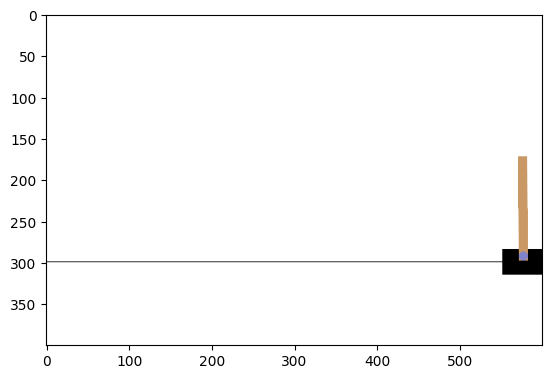

178.0

In [17]:
test(play=True)